In [400]:
import os
import cv2
import numpy as np
import math
import matplotlib.pyplot as plt
from skimage import io

TARGET_WIDTH = 500
TARGET_HEIGHT = 500
VALID_EXTENSIONS = ('.png', '.jpg', '.jpeg', '.bmp', '.tiff', '.gif', '.webp')

In [401]:
def resize_image(img):
    height, width, _ = img.shape
    # Determine the scaling factor to make the longer side 1000 pixels
    scale_factor = 500 / max(height, width)
    # Resize the image while preserving the aspect ratio
    img = cv2.resize(img, (int(width * scale_factor), int(height * scale_factor)))
    return img

In [402]:
def resize_image(img):
    height, width, _ = img.shape
    # Determine the scaling factor to make the longer side 1000 pixels
    scale_factor = 500 / max(height, width)
    # Resize the image while preserving the aspect ratio
    img = cv2.resize(img, (int(width * scale_factor), int(height * scale_factor)))
    return img

In [403]:
def get_clock_contour(image):
    circles = cv2.HoughCircles(image, cv2.HOUGH_GRADIENT, dp=0.8, minDist=500, param1=50, param2=30, minRadius=100, maxRadius=500)

    if circles is not None:
        circles = np.round(circles[0, :]).astype('int')
        for (x, y, r) in circles:
            center = (x, y)
            radius = r
    else:
        raise Exception('No circles were found.')
    return center, radius

In [404]:
def get_straight_lines(image, radius):
    """
    Detectează liniile drepte dintr-o imagine folosind transformata Hough.

    Parametri:
    - image: Imaginea de intrare.

    Returnează:
    - Lista de linii detectate sub forma
        [[[x1, y1, x2, y2]], ...].
    """
    _, thresholded = cv2.threshold(image, 120, 250, cv2.THRESH_BINARY_INV)
    lines = cv2.HoughLinesP(thresholded, 1, np.pi/180, 100, minLineLength=radius//3, maxLineGap=10)
    return lines

In [405]:
def is_line_on_circle(line, center, radius, tolerance=50):
    """
    Verifică dacă o linie este pe conturul cercului.

    Parametri:
    - line: Coordonatele liniei (x1, y1, x2, y2).
    - center: Centrul cercului (cx, cy).
    - radius: Raza cercului.
    - tolerance: Toleranța în pixeli față de raza cercului.

    Returnează:
    - True dacă linia este pe conturul cercului, False altfel.
    """
    x1, y1, x2, y2 = line
    dist1 = math.sqrt((x1 - center[0]) ** 2 + (y1 - center[1]) ** 2)
    dist2 = math.sqrt((x2 - center[0]) ** 2 + (y2 - center[1]) ** 2)
    return (abs(dist1 - radius) < tolerance and abs(dist2 - radius) < tolerance)

In [406]:
def filter_lines(lines, center, radius):
    """
    Filtrează liniile păstrând doar acelea care sunt complet în interiorul unui cerc.

    Parametri:
    - lines: Listă de linii [(x1, y1, x2, y2), ...].
    - center: Tuplu (cx, cy) care reprezintă centrul cercului.
    - radius: Raza cercului.

    Returnează:
    - Listă de linii care sunt complet în interiorul cercului.
    """
    cx, cy = center
    filtered_lines = []

    for line in lines:
        x1, y1, x2, y2 = line[0]
        dist1 = ((x1 - cx) ** 2 + (y1 - cy) ** 2) ** 0.5
        dist2 = ((x2 - cx) ** 2 + (y2 - cy) ** 2) ** 0.5

        if is_line_on_circle((x1, y1, x2, y2), center, radius):
            continue

        if dist1 <= radius and dist2 <= radius:
            filtered_lines.append(line)

    return filtered_lines

In [407]:
def merge_lines(lines, threshold_distance=30, threshold_angle=0.3):
    """
    Îmbină liniile care se suprapun sau sunt paralele, cu normalizarea coordonatelor.

    Parametri:
    - lines: Listă de linii detectate în formatul [[[x1, y1, x2, y2]], ...].
    - threshold_distance: Distanța maximă între capetele liniilor sau între linii suprapuse pentru a fi îmbinate.
    - threshold_angle: Diferența maximă de unghi între linii pentru a fi îmbinate (în radiani).

    Returnează:
    - Linii îmbinate, sortate descrescător după lungime.
    """
    def normalize_line(line):
        """Asigură că coordonatele unei linii sunt ordonate consistent."""
        x1, y1, x2, y2 = line
        if (x1, y1) > (x2, y2):
            return [x2, y2, x1, y1]
        return [x1, y1, x2, y2]

    def calculate_angle(line):
        """Calculează unghiul unei linii."""
        x1, y1, x2, y2 = line
        return np.arctan2(y2 - y1, x2 - x1)

    def are_lines_similar(line1, line2):
        """Verifică dacă două linii sunt similare (paralele și apropiate/suprapuse)."""
        angle1 = calculate_angle(line1)
        angle2 = calculate_angle(line2)

        if abs(angle1 - angle2) > threshold_angle:
            return False

        x1, y1, x2, y2 = line1
        x3, y3, x4, y4 = line2

        distances = [
            np.linalg.norm(np.array([x1, y1]) - np.array([x3, y3])),
            np.linalg.norm(np.array([x2, y2]) - np.array([x4, y4])),
            np.linalg.norm(np.array([x1, y1]) - np.array([x4, y4])),
            np.linalg.norm(np.array([x2, y2]) - np.array([x3, y3]))
        ]

        if min(distances) < threshold_distance:
            return True

        def point_to_line_distance(px, py, x1, y1, x2, y2):
            """Calculează distanța perpendiculară de la un punct la o linie."""
            return abs((y2 - y1) * px - (x2 - x1) * py + x2 * y1 - y2 * x1) / np.sqrt((y2 - y1)**2 + (x2 - x1)**2)

        dist1 = point_to_line_distance(x3, y3, x1, y1, x2, y2)
        dist2 = point_to_line_distance(x4, y4, x1, y1, x2, y2)

        return max(dist1, dist2) < threshold_distance

    normalized_lines = [normalize_line(line[0]) for line in lines]

    merged_lines = []
    used = set()

    for i, line1 in enumerate(normalized_lines):
        if i in used:
            continue
        x1, y1, x2, y2 = line1
        for j, line2 in enumerate(normalized_lines):
            if i == j or j in used:
                continue
            if are_lines_similar(line1, line2):
                # Combină liniile prin calcularea mediei capetelor lor
                x1 = (line1[0] + line2[0]) // 2
                y1 = (line1[1] + line2[1]) // 2
                x2 = (line1[2] + line2[2]) // 2
                y2 = (line1[3] + line2[3]) // 2
                used.add(j)
        merged_lines.append([[x1, y1, x2, y2]])

    return merged_lines

In [408]:
def normalize_line_orientation(line, center):
    """
    Reordonează coordonatele unei linii astfel încât capătul mai apropiat de centru să fie primul.

    Parametri:
    - line: Coordonatele liniei sub forma (x1, y1, x2, y2).
    - center: Coordonatele centrului (cx, cy).

    Returnează:
    - Linia reordonată sub forma (x1, y1, x2, y2).
    """
    x1, y1, x2, y2 = line
    distance1 = math.sqrt((x1 - center[0]) ** 2 + (y1 - center[1]) ** 2)
    distance2 = math.sqrt((x2 - center[0]) ** 2 + (y2 - center[1]) ** 2)
    if distance2 < distance1 or distance2-distance1<15:
        # Dacă al doilea capăt este mai aproape de centru, inversăm linia
        return x2, y2, x1, y1
    return x1, y1, x2, y2


In [409]:
def get_possible_hand_positions(lines, center):
    """
    Determine the possible positions of the clock hands.

    Parameters:
    - lines: List of lines detected in the form [[[x1, y1, x2, y2]], ...].
    - center: Coordinates of the circle's center (cx, cy).

    Returns:
    - Coordinates of possible hands as (hour_hand, minute_hand).
    """
    if not lines:
        return None, None  # No lines, no hands

    hour_hand = None
    minute_hand = None
    max_length = 0
    min_length = float('inf')

    for line in lines:
        x1, y1, x2, y2 = normalize_line_orientation(line[0], center)
        length = math.sqrt((x2 - x1) ** 2 + (y2 - y1) ** 2)

        if length > max_length:
            max_length = length
            minute_hand = (x1, y1, x2, y2)

        if length < min_length:
            min_length = length
            hour_hand = (x1, y1, x2, y2)

    return hour_hand, minute_hand


In [410]:
def calculate_angle(line, center):
    x1, y1, x2, y2 = line
    dx, dy = x2 - center[0], center[1] - y2
    angle = math.degrees(math.atan2(dy, dx))

    angle = (90 - angle) % 360
    return angle

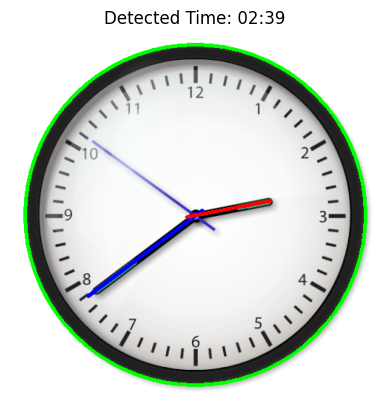

In [411]:
# functie care combina tot ce e mai sus pentru a afisa direct liniile
# pentru usurinta in a folosi mai multe imagini
def show_lines_analog_clock(input_image):
    L,C,pl =  np.shape(input_image)
    if pl>3:
        input_image = input_image[:,:,0:3]

    if input_image.dtype != np.uint8:
        input_image = (input_image * 255).astype(np.uint8)

    input_image = resize_image(input_image)

    if len(input_image.shape) == 3:
        image_gray = cv2.cvtColor(input_image, cv2.COLOR_RGB2GRAY)
    else:
        image_gray = input_image

    blurred = cv2.bilateralFilter(image_gray, d=9, sigmaColor=75, sigmaSpace=75)

    center, radius = get_clock_contour(blurred)
    cv2.circle(input_image, center, radius, (0, 255, 0), 3)
    lines = get_straight_lines(blurred, radius)
    filtered_lines = filter_lines(lines, center, radius)
    merged_lines = merge_lines(filtered_lines)
    hour_hand, minute_hand = get_possible_hand_positions(merged_lines, center)
    minute_angle = calculate_angle(minute_hand, center)
    hour_angle = calculate_angle(hour_hand, center)

    if minute_hand is not None:
        minute = round(minute_angle / 6) % 60 # Each minute represents 6 degrees
        cv2.line(input_image, (minute_hand[0], minute_hand[1]), (minute_hand[2], minute_hand[3]), (255, 0, 0), 3)

    if hour_hand is not None:
        if minute >= 30:
            hour_angle -= 15
        hour = round((hour_angle) / 30) % 12  # Each hour represents 30 degrees
        cv2.line(input_image, (hour_hand[0], hour_hand[1]), (hour_hand[2], hour_hand[3]), (0, 0, 255), 3)

    final_image = cv2.cvtColor(input_image, cv2.COLOR_BGR2RGB)

    return final_image, hour, minute


image = io.imread('images\\3.png')
final_image, hour, minute = show_lines_analog_clock(image)

plt.figure(), plt.imshow(final_image)
plt.title(f"Detected Time: {hour:02d}:{minute:02d}")
plt.axis('off')
plt.show()

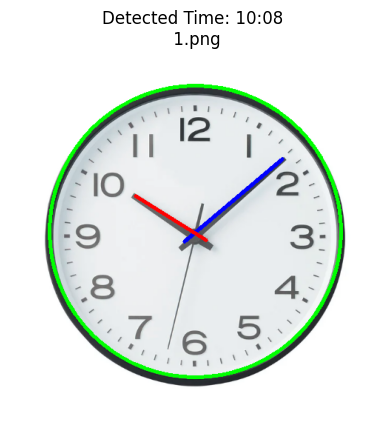

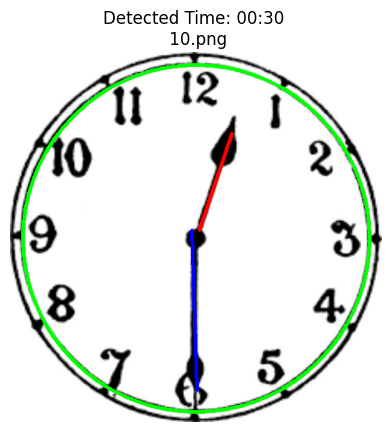

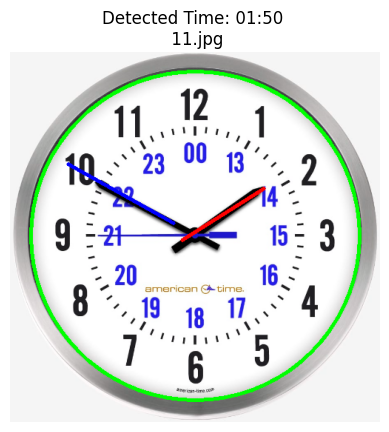

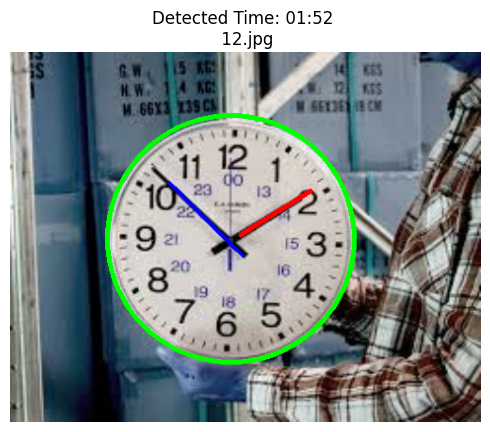

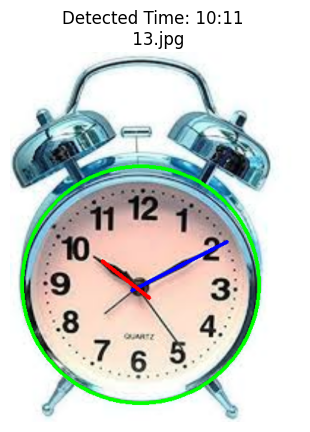

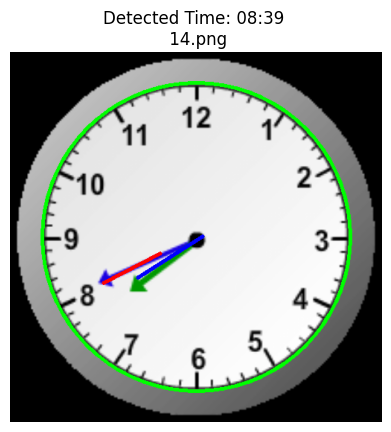

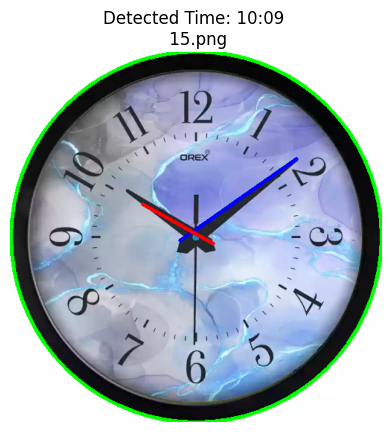

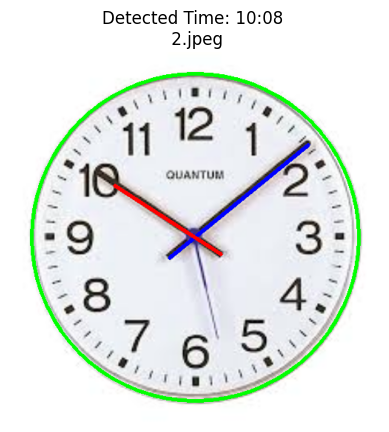

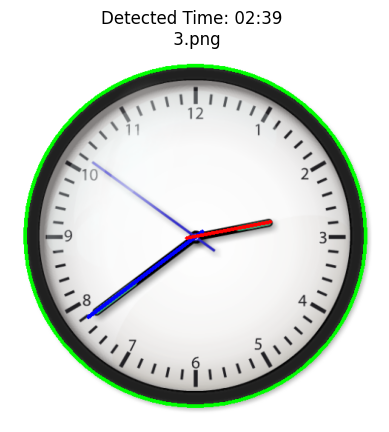

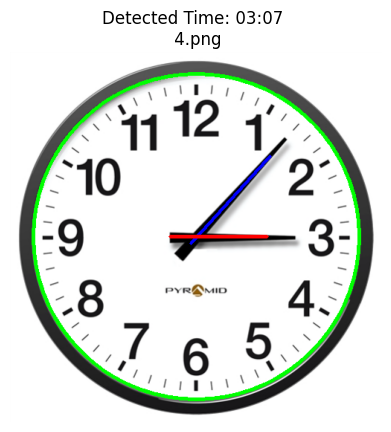

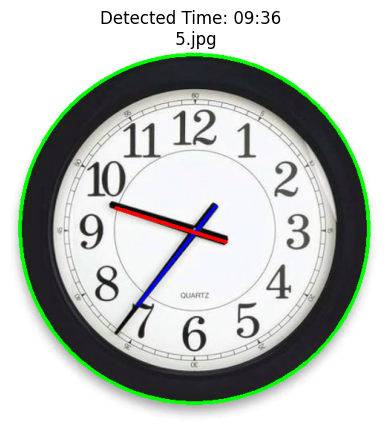

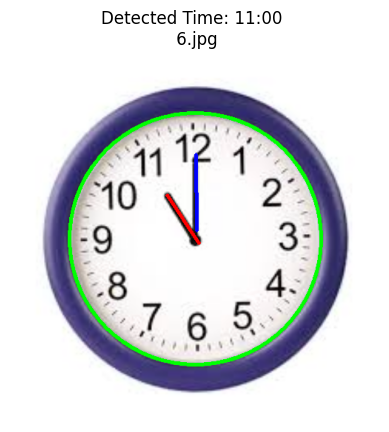

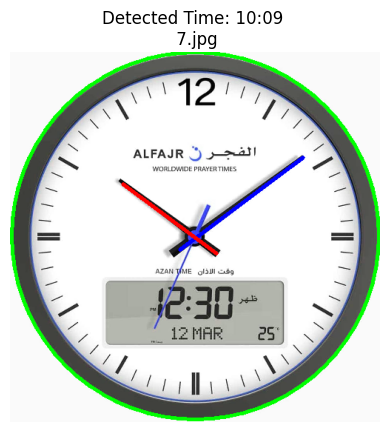

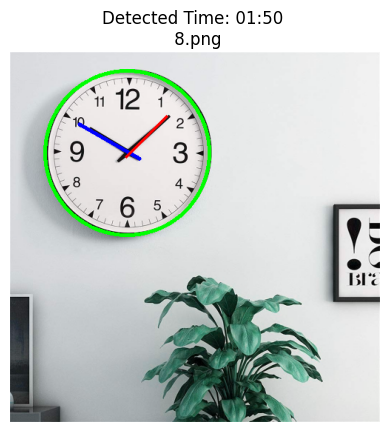

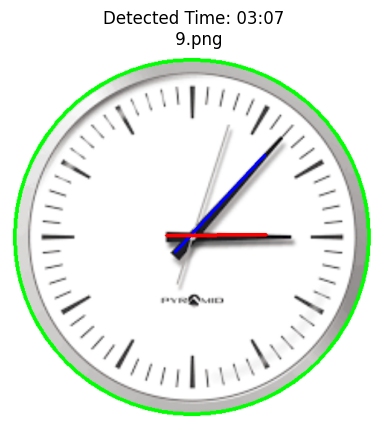

In [412]:
def process_image(filepath):
    image = io.imread(filepath)
    resulted_image, resulted_hour, resulted_minute = show_lines_analog_clock(image)
    display_image(resulted_image, resulted_hour, resulted_minute, filepath)


def display_image(image, hour, minute, filename):
    plt.figure()
    plt.imshow(image)
    plt.title(f"Detected Time: {hour:02d}:{minute:02d} \n {os.path.basename(filename)}")
    plt.axis('off')
    plt.show()


def process_images_from_folder(folder_path):
    for filename in os.listdir(folder_path):
        filepath = os.path.join(folder_path, filename)

        if filename.lower().endswith(VALID_EXTENSIONS):
            process_image(filepath)

process_images_from_folder('images')